In [18]:
# 

#conda activate ImageAnalysis
#Environment to activate on Jacques's machine

#%gui qt
#%matplotlib widget

import math
import sys
import numpy as np
import pywt
import scipy as sc
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
import cv2 as cv2
import pandas as pd
import cmath

from skimage import io, transform
from skimage.color import rgb2gray, label2rgb
from skimage.measure import label, regionprops, regionprops_table
from skimage import data, util
from skimage.filters import gaussian, median, threshold_otsu, threshold_local
from skimage.segmentation import active_contour
from skimage.transform import rescale
from skimage.morphology import closing, square, disk
from skimage.segmentation import clear_border



from IPython import display

plt.rcParams['figure.figsize'] = [15, 5]


"""
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
"""

def gui_fname(dir=None):
    """Select a file via a dialog and return the file name."""
    if dir is None: dir ='./'
    fname = QFileDialog.getOpenFileName(None, "Select data file...", 
                dir, filter="TIFF (*.tif) ;; AVI (*.avi)")
    
    filename = fname[0].split('/')[-1]
    path=fname[0].replace(filename, '')
    
    return (path, filename, fname[1])

def import_image(filename: str, max_frames: int) -> np.ndarray:
    """
    Retrieve an tiff image stack in a numpy array
    max_frames : maximum number of frames. 0 by default: all frames are loaded
    """

    NameFileParsed = filename.split(".")
    print(NameFileParsed[-1])

    if NameFileParsed[-1] == ("tif" or "tiff"):
        Image = io.imread(filename)
        Image.astype(float)

        if max_frames > Image.shape[0]:
            max_frames = Image.shape[0]

        if max_frames != 0:
            Image = Image[
                :max_frames,
            ]
        print("TIF stack loading OK")

    elif NameFileParsed[-1] == "avi":
        Cap = cv.VideoCapture(filename)
        frame_count = int(cv.VideoCapture.get(Cap, int(cv.CAP_PROP_FRAME_COUNT)))

        if max_frames > frame_count:
            max_frames = frame_count

        if max_frames != 0:
            Frames = max_frames

        Width = int(cv.VideoCapture.get(Cap, int(cv.CAP_PROP_FRAME_WIDTH)))
        Height = int(cv.VideoCapture.get(Cap, int(cv.CAP_PROP_FRAME_HEIGHT)))
        Temp = np.zeros((Frames, Height, Width))

        for framenumber in range(Frames):
            if (framenumber + 1) % 10 == 0:
                print("Frame number = ", framenumber + 1)

            ret, frame = Cap.read()
            # if frame is read correctly ret is True
            if not ret:
                print("Can't receive frame (stream end?). Exiting...")
                break
            Temp[framenumber::] = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        Cap.release()
        Image = Temp
        print("AVI loading OK")
    else:
        raise RuntimeError("The file extension should be .tif, .tiff or .avi.")

    NImage = Image.shape[0]
    HImage = Image.shape[1]
    WImage = Image.shape[2]
    return Image, NImage, HImage, WImage


print("Librairies Loading OK")

Librairies Loading OK



# Loading and Contouring

## Parameters

In [19]:
#Rescale factor
rescale_factor=1

#Binning number
binning=100

#Measurement cut_off (pixels)
cut_off = 100 #px

#Active contour
#original : alpha=0.02, beta=10, gamma=0.001
alphA = 0.01
betA=1

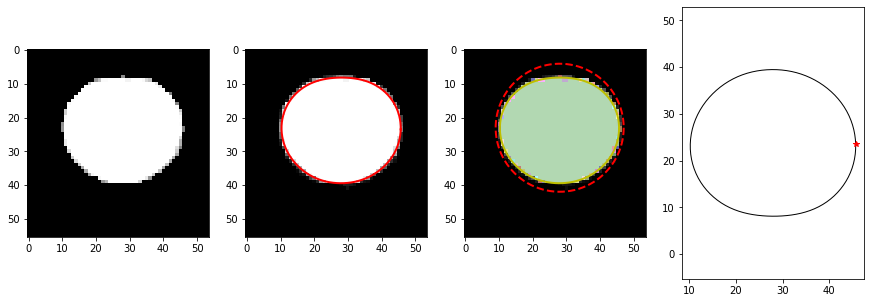

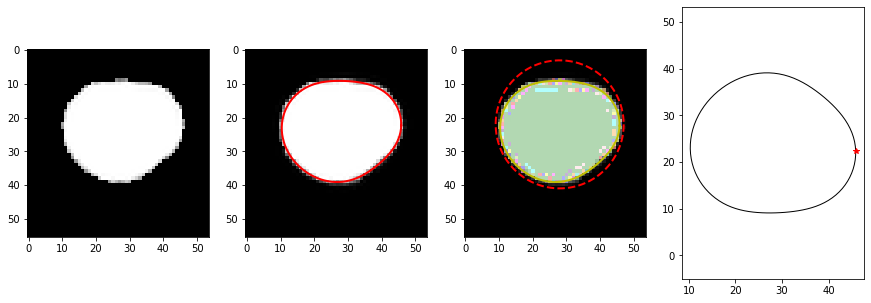

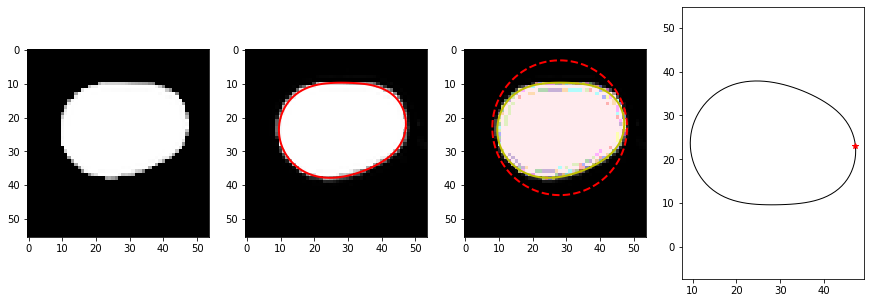

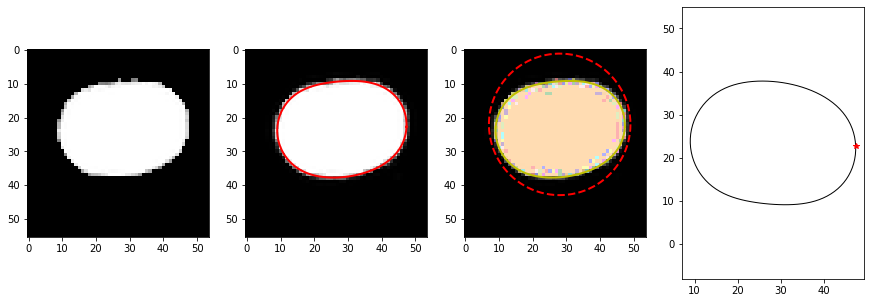

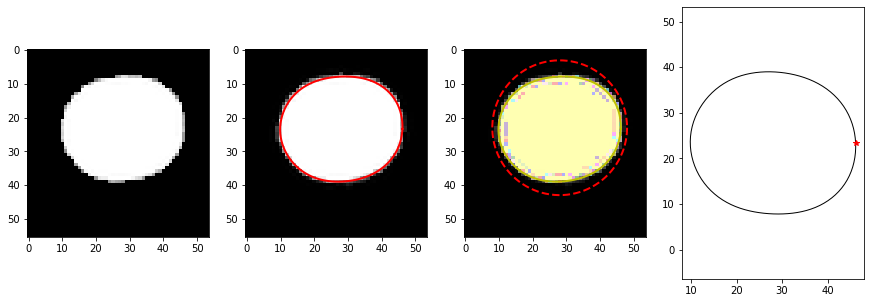

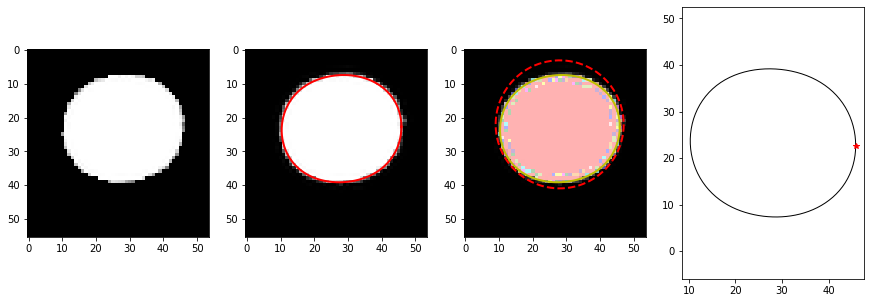

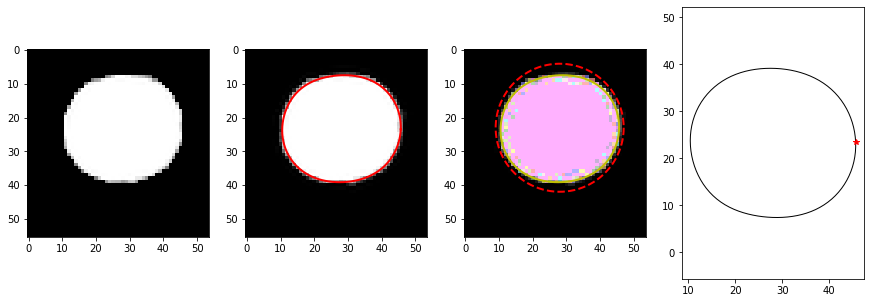

In [20]:
#Loading file
filename="./Data/Image18-4-NileRed-MedianFiji.tif"
img = io.imread(filename)

#Median blur on the stack to remove isolated pixels
med = img#cv2.medianBlur(img,1)


#List of results
track=[]
results=pd.DataFrame()
temp_results = pd.DataFrame()

#Construction de la colonne d'index
indexe=np.zeros((img.shape[0]*binning, 1))

#For each frame of the stack
for i in range(img.shape[0]):
    
    #Opencv : Contouring
    
    ## Apply threshold (Otsu)
    thresh = threshold_otsu(med[i,:,:])

    bw = closing(med[i,:,:] > thresh, square(3))
    bw=bw*med[i,:,:]
    bw2=util.img_as_ubyte(rescale(bw, rescale_factor))
    bw3 = threshold_local(img[i,:,:], 3)
    img2=util.img_as_ubyte(rescale(img[i,:,:],rescale_factor))
    
    #SKimage active contouring
    
    ## Initialization circle : Min enclosing circle
    _,contours,_ = cv2.findContours(bw2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt=contours[0]
    
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    radius = int(1.1*radius)
    
    s = np.linspace(0, 2*np.pi, binning)
    r = center[1] + radius*np.sin(s)
    c = center[0] + radius*np.cos(s)
    init = np.array([r, c]).T
    
    ##Compute the snake
    snake = active_contour(gaussian(img2, 3, preserve_range=False),init, boundary_condition='periodic',  
                           alpha=alphA, beta=betA) 
    
    first_line=np.array([snake[0,0], snake[0,1]]).T
    #print(first_line.shape)
    snake = np.append(snake, [first_line], axis=0)
    #print('snake', snake.shape)

    f = sc.interpolate.interp1d(snake[:,0], snake[:,1])
    
    temp_results['Contour_x']=snake[:,0]
    temp_results['Contour_y']= f(snake[:,0])#
    #temp_results['Contour_y']=snake[:,1]
    temp_results['Frame number']=i+1
    temp_results['Frame number'] = pd.Series(i+1, index=temp_results.index)


    
    #Measure properties
    # remove artifacts connected to image border
    cleared = clear_border(bw)
    label_img = label(cleared)    
    image_label_overlay = label2rgb(label_img, image=img[i,:,:], bg_label=0)    
    regions = regionprops(label_img) 
    
    #display.display(temp_results)
    if len([prop for prop in regions if prop.area>cut_off])!=1:
        raise ValueError('The cut_off should be changed to select less objects')
    for prop in regions:
        if prop.area >10:
            track.append((prop.centroid, prop.area, prop.orientation))
            temp_results['Centroid x']=prop.centroid[0]
            temp_results['Centroid y']=prop.centroid[1]
            temp_results['Area']=prop.area
            temp_results['Orientation']=prop.orientation    

    # Compute the coordinates of the particle translated to the origin
    temp_results['Contour Translated x']=temp_results['Contour_x'] - temp_results['Centroid x']
    #print(len(results))
    temp_results['Contour Translated y']=temp_results['Contour_y'] - temp_results['Centroid y']

    
    #Polar coordinates
    temp_results['Polar r'] = 0.0
    temp_results["Polar phi"] = 0.0
    
    for idx in range(len(temp_results)):
        cplx = complex(temp_results.at[idx, 'Contour Translated x'], temp_results.at[idx, 'Contour Translated y'])
        r,theta = cmath.polar(cplx)
        temp_results.at[idx, 'Polar r'] = r
        temp_results.at[idx, 'Polar phi'] = theta
        
    #temp_results['Polar phi'] = np.roll(temp_results['Polar phi'],int(binning/4))
    
    #display.display(temp_results)

    for j in range(i*binning, (i+1)*binning):
        indexe[j,0]=int(j)
                
    #Append the temporary DataFrame to the final one
    
    results = results.append(temp_results)
    temp_results = pd.DataFrame()
    #print('temp', temp_results)
    results.reset_index(inplace=True, drop=True) 
    
    #Reindex
    #print("Frame", i, "over", med.shape[0])
    
    
# Plotting of the contouring

    fig, ax = plt.subplots(1, 4)

    #Display the dimensions of each frame
    #print ("The dimensions of the frames are : ", bw2.shape)

    #Display the bw picture + the active contour
    ax[0].imshow(bw2, cmap=plt.cm.gray)

    ax[1].imshow(med[i,:,:], cmap=plt.cm.gray)
    ax[1].plot(snake[:, 1], snake[:, 0], '-r', lw=2)

    ax[2].imshow(img2, cmap=plt.cm.gray)
    ax[2].imshow(image_label_overlay)
    ax[2].plot(init[:, 1], init[:, 0], '--r', lw=2)
    ax[2].plot(snake[:, 1], snake[:, 0], '-y', lw=2)

    ax[3].plot(snake[:,1], snake[:,0], '-k', lw=1)
    ax[3].plot(snake[0,1], snake[0,0], '*r', lw=4)
    ax[3].axis('equal')

    #plt.show()
    
    
    
#Computation of the curvature in cartesian coordinates
results['Polar Local Curvature']=0.0

for i in range(1, img.shape[0]+1):

    r=results.loc[results['Frame number']==i]['Polar r']
    theta=results.loc[results['Frame number']==i]['Polar phi']
    drdt = np.gradient(r, theta)
    ddrdtt = np.gradient(drdt, theta)
    curvature = abs(r**2+2*drdt**2-r*ddrdtt)/(r**2+drdt**2)**(3/2)
    results.loc[results['Frame number']==i, 'Polar Local Curvature']= curvature

results['Curvature Radius'] = 1/results['Polar Local Curvature']

#Saving to Excel file
results.to_excel("output.xlsx")

## Plotting of the curvature in polar coordinates

This step is optional

"\nfig, ax = plt.subplots()\nax.plot(results['Centroid x' and results['Frame number']==1], results['Centroid y'and results['Frame number']==1], '*-k', lw=1)\nax.set_xlabel(r'x (px)', fontsize=15)\nax.set_ylabel(r'y (px)', fontsize=15)\nax.set_title('Centroid tracking over time')\nfig.tight_layout()\n"

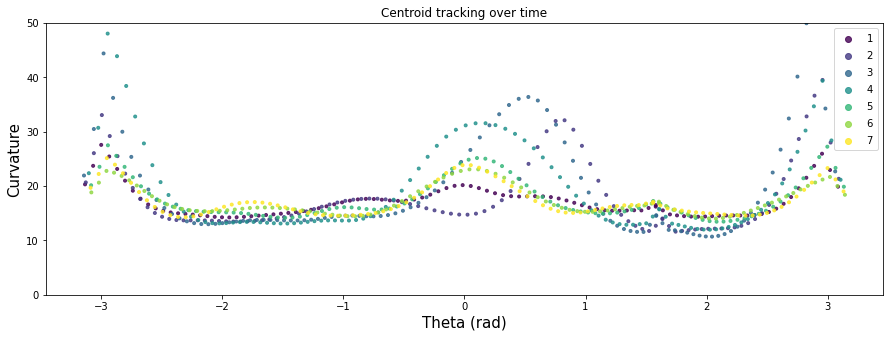

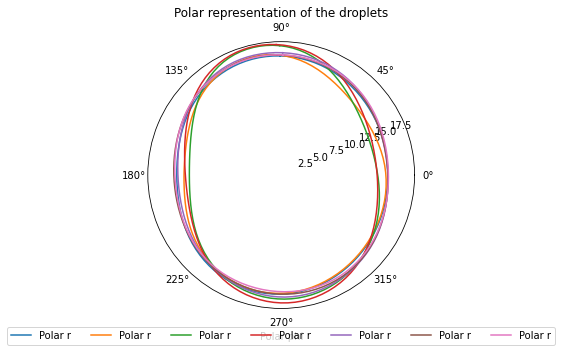

In [23]:
fig, ax = plt.subplots()

sc = ax.scatter(results['Polar phi'], results['Curvature Radius'], marker = '.', c = results['Frame number'], alpha = 0.8)
#results.groupby('Frame number').plot('Polar phi', 'Curvature Radius', ax=plt.gca(), kind='scatter', c = results['Frame number'])
ax.legend(*sc.legend_elements())
ax.set_xlabel('Theta (rad)', fontsize=15)
ax.set_ylabel('Curvature', fontsize=15)
ax.set_title('Centroid tracking over time')
#ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=False, ncol=5)
ax.set_ylim([0, 50])
#ax.set_xlim([1.4, 1.8])


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
results.groupby('Frame number').plot('Polar phi', 'Polar r', ax=plt.gca())
#ax.plot(0, 0, '*r', lw=4)
ax.set_title('Polar representation of the droplets')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=False, ncol=10)
#ax.set_thetamin(80)
#ax.set_thetamax(100)
fig.tight_layout()


"""
fig, ax = plt.subplots()
ax.plot(results['Centroid x' and results['Frame number']==1], results['Centroid y'and results['Frame number']==1], '*-k', lw=1)
ax.set_xlabel(r'x (px)', fontsize=15)
ax.set_ylabel(r'y (px)', fontsize=15)
ax.set_title('Centroid tracking over time')
fig.tight_layout()
"""

# Analysis of the full sequence : 
- Tracking of the position
- Tracking of the orientation
- Tracking of the speed
- Plot the movie of the deformation (same origin) + colormap = curvature


In [63]:
results['Local Curvature']=0.0

for i in range(1, img.shape[0]+1):
    print(i)
    #Computation of the curvature in cartesian coordinates
    #dx = np.diff(results.loc[results['Frame number']==i]['Contour Translated x'], prepend=results.at[0,'Contour Translated x'])
    #dy = np.diff(results.loc[results['Frame number']==i]['Contour Translated y'], prepend=results.at[0,'Contour Translated y'])
    #ddx = np.diff(dx,prepend=dx[0])
    #ddy = np.diff(dy, prepend=dy[0])
    x=results.loc[results['Frame number']==i]['Contour Translated x']
    y=results.loc[results['Frame number']==i]['Contour Translated y']
    dydx = np.gradient(y, x)
    ddydxx = np.gradient(dydx, x)
    #print(abs((ddydxx) / ((1+dydx**2)**(3/2))))
    print(ddydxx.shape)
    #results.loc[results['Frame number']==i, 'Local Curvature']= (ddy * dx - ddx * dy) / ((dx**2 + dy**2)**(3/2))    
    results.loc[results['Frame number']==i, 'Local Curvature']= abs((ddydxx) / ((1+dydx**2)**(3/2)))


results['Curvature Radius'] = 1/results['Local Curvature']

#Computation of the curvature in polar coordinates
for i in range(1, img.shape[0]+1):
    #Computation of the curvature in cartesian coordinates
    #dx = np.diff(results.loc[results['Frame number']==i]['Contour Translated x'], prepend=results.at[0,'Contour Translated x'])
    #dy = np.diff(results.loc[results['Frame number']==i]['Contour Translated y'], prepend=results.at[0,'Contour Translated y'])
    #ddx = np.diff(dx,prepend=dx[0])
    #ddy = np.diff(dy, prepend=dy[0])
    dr = np.gradient(results.loc[results['Frame number']==i]['Polar r'])
    dphi = np.gradient(results.loc[results['Frame number']==i]['Polar phi'])
    ddr = np.gradient(dr)
    ddphi = np.gradient(dphi)
    #results.loc[results['Frame number']==i, 'Local Curvature']= (ddy * dx - ddx * dy) / ((dx**2 + dy**2)**(3/2))

results['Curvature Radius'] = 1/results['Local Curvature']

results['diff Polar r']= np.gradient(results['Polar r'])
results['diff Polar phi']= np.gradient(results['Polar phi'])
results['ddiff Polar r']= np.diff(results['diff Polar r'], prepend=0)
results['r_prime']=results['diff Polar r']/results['diff Polar phi']
results['r_second']=results['ddiff Polar r']/results['diff Polar phi']
#results['Local Curvature'] = abs(results['Polar r']+2*dr**2 - results['Polar r']*ddr)/(dr**2 + ddr**2)**(3/2)
#results['Curvature Radius'] = 1/results['Local Curvature']

#Computation of the curvature in cartesian coordinates
phi = results['diff Polar phi']

'''
dx = np.gradient(results['Contour Translated x'])
dy = np.gradient(results['Contour Translated y'])
ddx = np.gradient(dx)
ddy = np.gradient(dy)
dydx = np.gradient(results['Contour Translated y'], results['Contour Translated x'])
ddydxx = np.gradient(dxdy, results['Contour Translated x'])
#Calcul de la courbure en coordonnées cartésiennes

results['Local Curvature']= (ddydxx) / ((1+dydx**2)**(3/2))
#results['Local Curvature']= (ddy * dx - ddx * dy) / ((dx**2 + dy**2)**(3/2))

#Calcul du rayon de courbure
results['Curvature Radius'] = 1/results['Local Curvature']
'''



print("Analysis of the full sequence OK")
    

1
(101,)
2
(101,)
3
(101,)
4
(101,)
5
(101,)
6
(101,)
7
(101,)
Analysis of the full sequence OK


## Saving the raw results as an xls file

This step is optional

In [ ]:
#print (results)
results.to_excel("Curvature.xlsx")
     
#viewer = napari.view_image(img, name="Original data")
#viewer.add_image(med, name="Original data")

#print(viewer)

## Bac à sable

In [ ]:
import random

polar=np.zeros((77, 2))
"""
for idx in range(polar.shape[0]):
    print(idx)
    input_num = complex(results['Contour Translated x'][idx], results['Contour Translated y'][idx])
    r, phi = cmath.polar(input_num)
    results['Polar r'][idx] = r
    results['Polar phi'][idx] = phi
    print(results['Polar r'][idx], results['Polar phi'][idx])
    
print(results['Polar r'])
"""
    

In [ ]:
display.display(results)

In [ ]:
complex(1,3)